# Load packages and data stuff

In [1]:
%load_ext tensorboard
from helpers_image_pricecat import *
import os
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pandas as pd

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

Init Plugin
Init Graph Optimizer
Init Kernel


Load the listings and extract the price

In [2]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
urls = listings["listing_url"]
ids = listings["id"]
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
price = pd.DataFrame(price)
price["log_price"] = np.log(price)
price["id"] = listings["id"]
price = price[["id", "price", "log_price"]]

In [3]:
# MAKE PRICE CATEGORIES

# form size dependent groups
listings["size_group"] = listings["accommodates"].astype(str)

# consider all listings that are for more than 6 people as one group
filter = listings["accommodates"] > 6
listings["size_group"][filter] = "greater 6"

# construct new column that is basically the price of the listing. Only correct the price for the group >6 by dividing by accommodates
listings["price_adj"] = price["price"]
listings["price_adj"][filter] = (price["price"]/listings["accommodates"])[filter]

# find the group specific quantiles
quantiles = listings.groupby(listings["size_group"]).quantile([0,0.1,0.4,0.6,0.9,1])["price_adj"]

# construct new column that gives the price category in the groups by taking the group quantiles into account
listings["price_category"] = np.repeat(None, len(listings))
for size_gr in np.unique(listings["size_group"]):
    filter = listings["size_group"] == size_gr
    q = quantiles[size_gr]
    # adjust lower and upper bound
    q[0] = q[0]-1
    q[1] = q[1]+1
    listings["price_category"][filter] = pd.cut(listings["price_adj"][filter], bins = q, labels = ["very cheap", "cheap", "middle", "expensive", "very expensive"])


In [4]:
listings["accommodates"].value_counts()

2     3213
4     1211
1     1066
6      453
3      383
5      296
7      132
8      129
10      28
12      18
9       17
11      11
16       7
14       5
15       4
13       3
Name: accommodates, dtype: int64

Set the path to the downloaded and resized images

In [5]:
folder_images = "data/images_resized"
img_path = os.listdir(folder_images)

Set up a dataframe which contains the listing id the number of the image for the id and its corresponding path alongside with the price category

In [6]:
images_path = pd.Series(img_path)
listing_ids = np.squeeze(images_path.str.extract("(^\d*_\d*)").values)

In [7]:
images_df = pd.Series(listing_ids).str.split("_", expand = True)
images_df.columns = ["id", "img_no"]
images_df["img_path"] = [str(l) + ".png" for l in list(listing_ids)]

# .DS -File is also in folder. Drop that row
images_df = images_df.dropna()
images_df

,id,img_no,img_path
0,19917816,12,19917816_12.png
1,15814444,6,15814444_6.png
2,23958167,21,23958167_21.png
3,9851118,0,9851118_0.png
4,51243476,13,51243476_13.png
...,...,...,...
86441,22159651,6,22159651_6.png
86442,30737269,10,30737269_10.png
86443,24031304,6,24031304_6.png
86444,6580137,6,6580137_6.png


In [8]:
# join prices and df with ids, img_no and paths
listings["id"] = listings["id"].astype(int)
images_df["id"] = images_df["id"].astype(int)
img_list_df = images_df.merge(listings[["id", "price_category"]], how = "left", on = "id")
img_list_df["id"] = img_list_df["id"].astype(str)

unique_ids = np.unique(img_list_df["id"])

# Model for collage of 5 images

In [9]:
# only first 5 pictures of each id
df_collage = img_list_df[img_list_df["img_no"].astype(int)<=4]

# dataframe with id and its price category
id_price_df = df_collage[["id", "price_category"]]
id_price_df = id_price_df.drop_duplicates()

# unique id with its price category
unique_ids = id_price_df["id"].astype(str)
unique_price = id_price_df["price_category"]
img_stacked = []

In [10]:
from sklearn import preprocessing
# store label in one column
le = preprocessing.LabelEncoder()
le.fit(id_price_df["price_category"])
id_price_df["price_category_label"] = le.transform(id_price_df["price_category"])

In [11]:
id_price_df

,id,price_category,price_category_label
3,9851118,cheap,0
8,13071668,very cheap,3
10,30948708,middle,2
16,51031542,middle,2
20,20358903,middle,2
...,...,...,...
84352,9675449,expensive,1
84760,9861180,middle,2
85187,11620981,cheap,0
85503,24332653,middle,2


Save collage images

In [43]:
for id in tqdm(unique_ids):
    filter = df_collage["id"] == id
    paths = df_collage["img_path"][filter]
    img_tmp = []
    counter = 0
    for p in np.tile(paths, 5):
        img_tmp.append(cv2.imread("data/images_resized/"+p))
        counter += 1
        if counter == 5:
            break

    #for p in paths:
    #    img_tmp.append(cv2.imread("data/images_resized/"+p))

    img_tmp = np.hstack(img_tmp)
    cv2.imwrite("data/image_collage/"+id+".png", img_tmp)

100%|██████████| 6315/6315 [02:33<00:00, 41.03it/s]


In [11]:
id_price_df["price_category"].value_counts()

cheap             1868
expensive         1788
middle            1351
very cheap         703
very expensive     605
Name: price_category, dtype: int64

Create train, test, val data from collages

In [16]:
X_train, X_test, y_train, y_test = train_test_split(id_price_df["id"].values, id_price_df["price_category_label"].values, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

Write tfr-files for each of the sets

In [12]:
write_features(X_train, X_train+".png", y_train, path = "data/image_collage/", filename = "data/tfrecord_collage_cat/train_collage")

write_features(X_val, X_val+".png", y_val, path = "data/image_collage/", filename = "data/tfrecord_collage_cat/val_collage")

write_features(X_test, X_test+".png", y_test, path = "data/image_collage/", filename = "data/tfrecord_collage_cat/test_collage")

NameError: name 'X_train' is not defined

In [13]:
train_dataset = make_dataset("data/tfrecord_collage_cat/train_collage.tfr", batch_size = 16)
test_dataset = make_dataset("data/tfrecord_collage_cat/test_collage.tfr", batch_size = 16)
val_dataset = make_dataset("data/tfrecord_collage_cat/val_collage.tfr", batch_size = 16)

We will now use different pretrained nets for feature extraction. Aferwards we will visualize which parts of the collages were important for the price prediction

We might need a learning rate scheduler. Try a decrease after 5 epochs

In [15]:
def scheduler(epoch, lr):
  if epoch%10 == 0:
    print("UPDATE LR: "+str(np.round(lr,5)))
    return lr * 0.1
  else:
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## ResNet

### Model 

In [14]:
# Save training in Tensorboard 
logdir = "logs/collage_cat/resnet"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Define Input
inputs = tf.keras.layers.Input(shape = (None, None, 3), name = "input_1")

# Load ResNet with pretrained Imagenet weights
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet', input_tensor=inputs, pooling="avg")

# freeze the weights
resnet.trainable = False

# Layer 1 - Flatten
outputs = tf.keras.layers.Flatten()(resnet.output)
# Layer 2 - Dense ReLu
outputs = tf.keras.layers.Dense(300, activation = "relu")(outputs)
# Layer 3 - Dense Output 
outputs = tf.keras.layers.Dense(5)(outputs)

# Combine pretrained and output model
model_resnet = tf.keras.Model(inputs, outputs)

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics=["accuracy"])
model_resnet.fit(train_dataset, validation_data = val_dataset , epochs = 10, callbacks = [tensorboard_callback])

2022-01-11 12:04:55.540206: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-11 12:04:55.540470: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-01-11 12:04:55.542220: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-01-11 12:04:56.550442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-11 12:04:56.552708: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-01-11 12:04:57.505360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


      1/Unknown - 4s 4s/step - loss: 2.0320 - accuracy: 0.0625

2022-01-11 12:05:00.611570: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-01-11 12:05:00.613291: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


      2/Unknown - 6s 2s/step - loss: 12.7197 - accuracy: 0.2812

2022-01-11 12:05:02.620923: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-01-11 12:05:02.630391: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-01-11 12:05:02.641165: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/collage_cat/resnet/train/plugins/profile/2022_01_11_12_05_02
2022-01-11 12:05:02.643106: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/collage_cat/resnet/train/plugins/profile/2022_01_11_12_05_02/Air-von-Dominik.fritz.box.trace.json.gz
2022-01-11 12:05:02.654073: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/collage_cat/resnet/train/plugins/profile/2022_01_11_12_05_02
2022-01-11 12:05:02.654278: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/collage_cat/resnet/train/plugins/profil

     89/Unknown - 194s 2s/step - loss: 4.5322 - accuracy: 0.2711

In [20]:
model_resnet.save("img_models/resnet_collage")

2022-01-04 07:48:10.182040: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: img_models/resnet_collage/assets


### Visualization

We have to define some functions first (see Keras documentation GradCam)

In [21]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image


    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [22]:
# get test cases
for i in val_dataset.take(1):
  img_arrays = i[0]["input_1"]
  prices = i[1]

model_builder = model_resnet
preprocess_input = keras.applications.resnet.preprocess_input
last_conv_layer_name = "conv5_block3_3_conv"
b, w, h, d = img_arrays.shape

2022-01-04 07:55:01.444461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Predicted:  90.64211
True:  100.99999


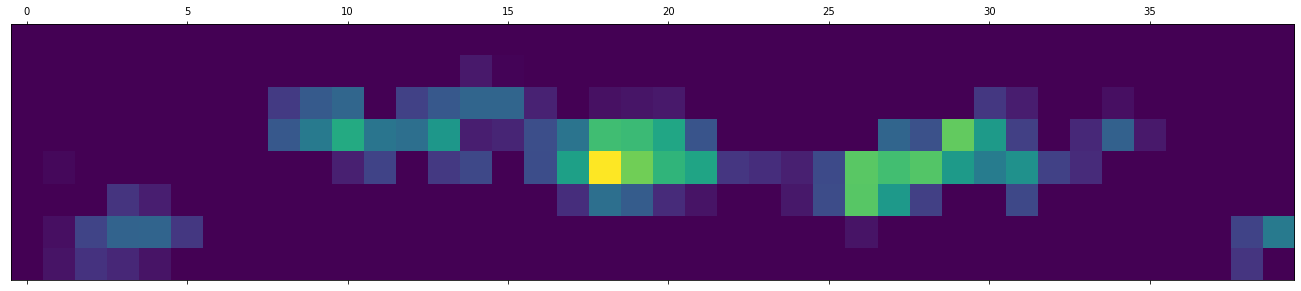

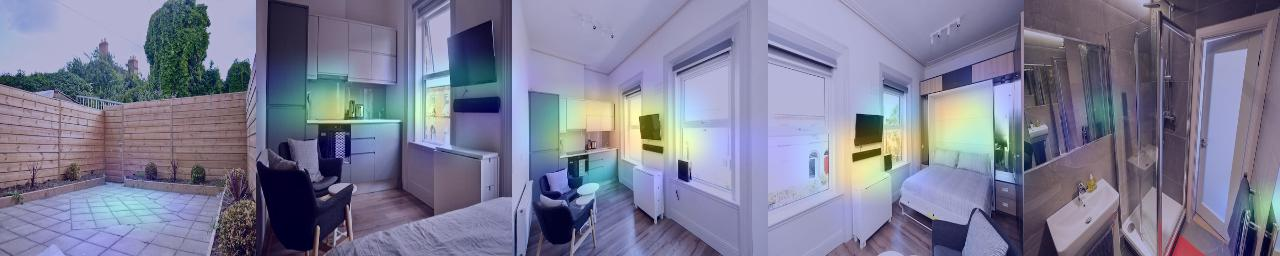

Predicted:  31.832426
True:  55.000004


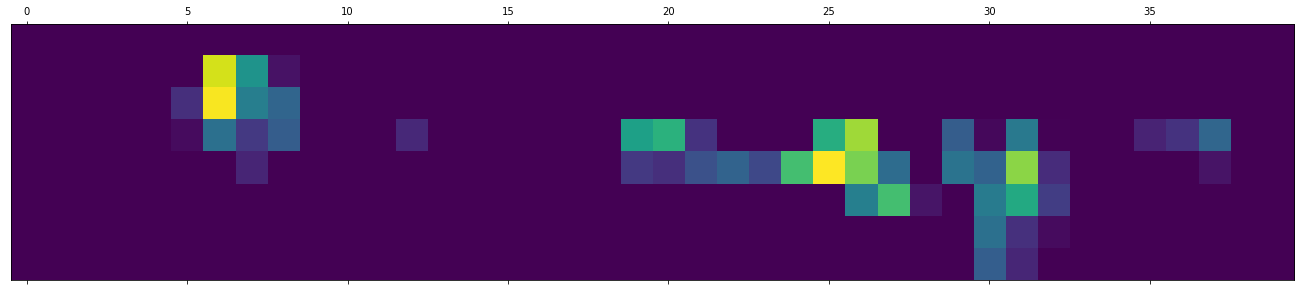

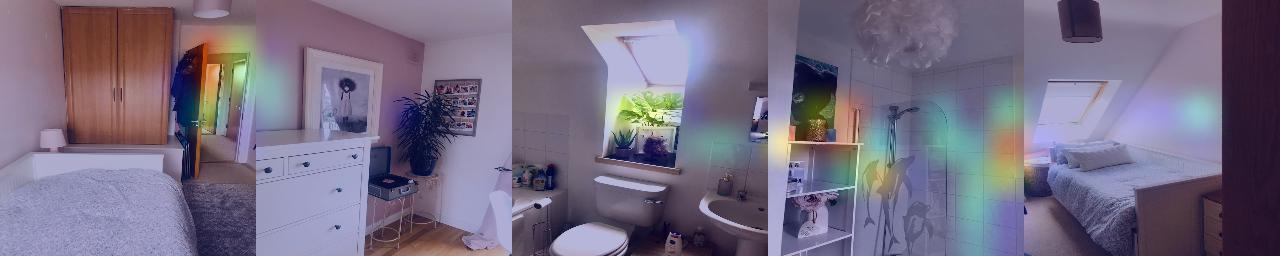

Predicted:  131.01512
True:  95.0


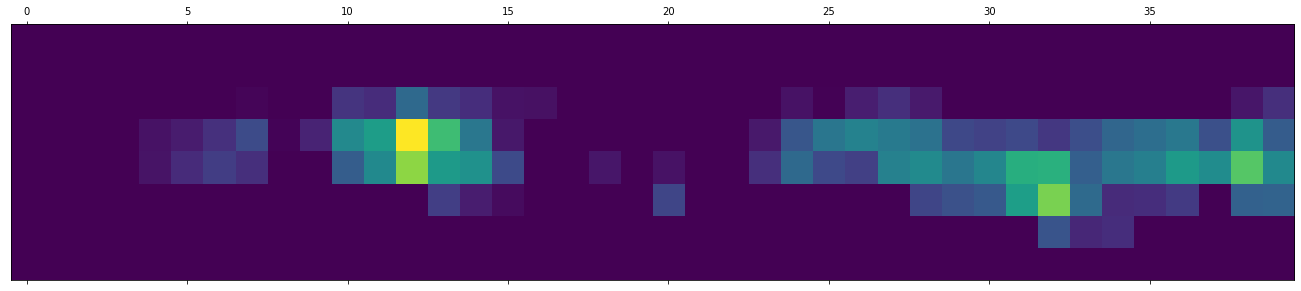

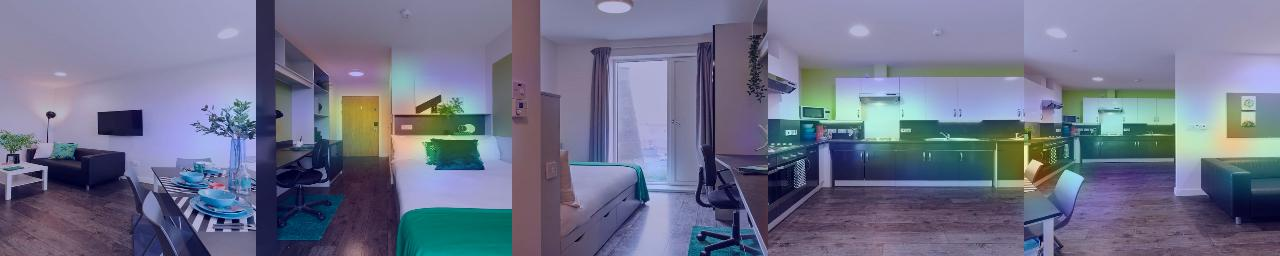

Predicted:  45.811337
True:  104.999985


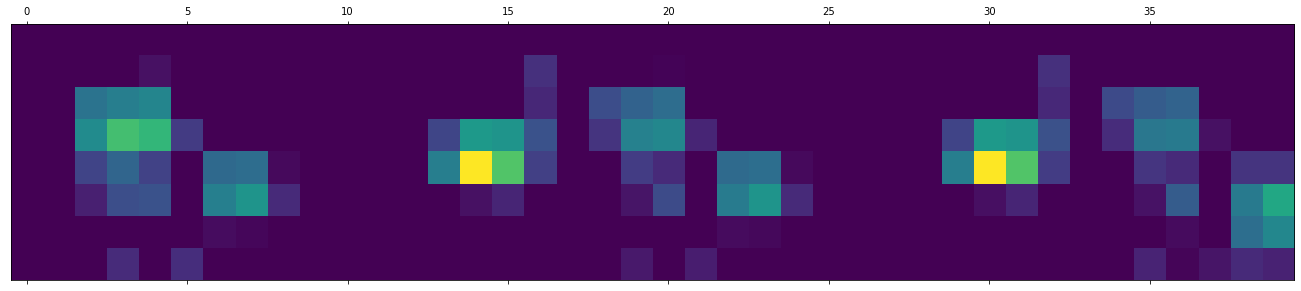

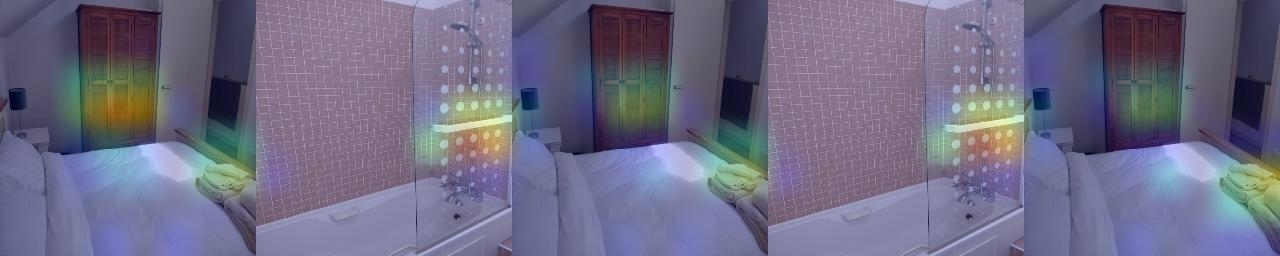

Predicted:  36.665176
True:  50.000004


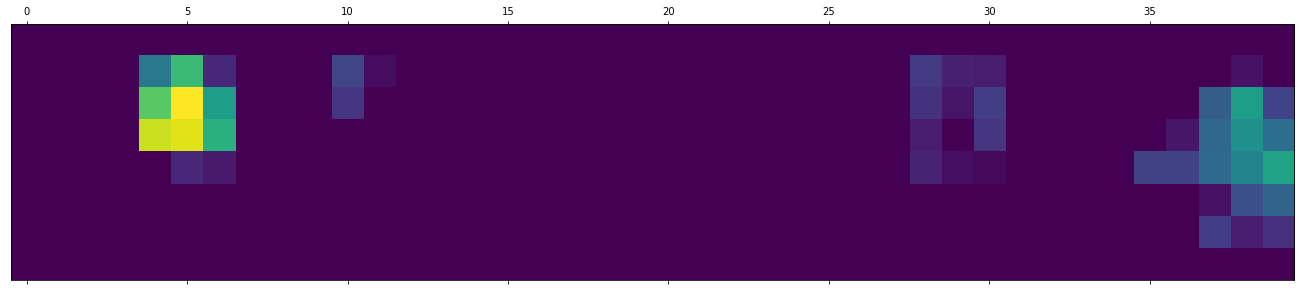

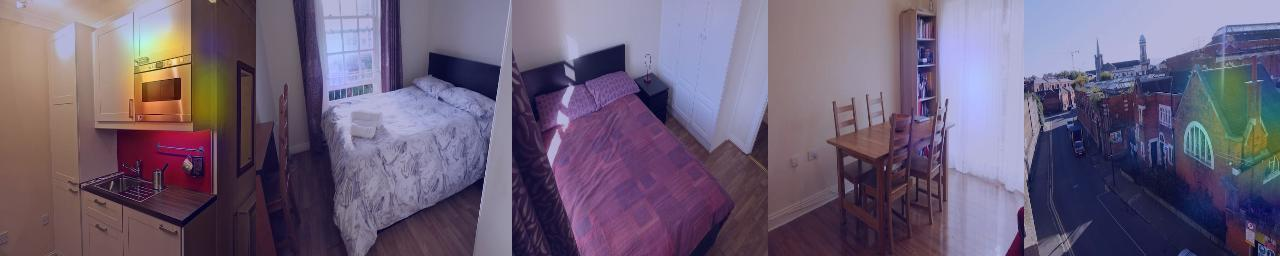

Predicted:  34.55466
True:  50.000004


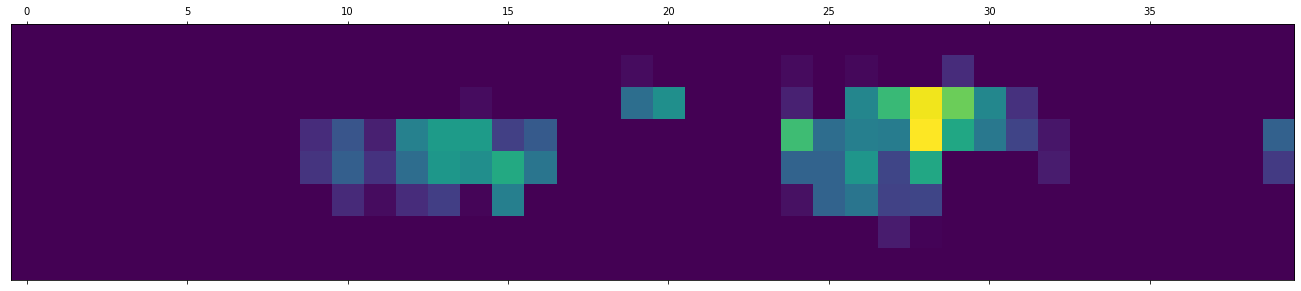

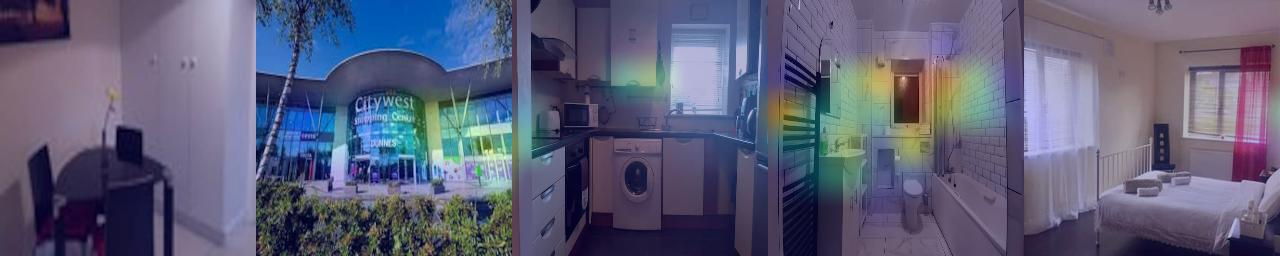

Predicted:  33.62466
True:  30.000002


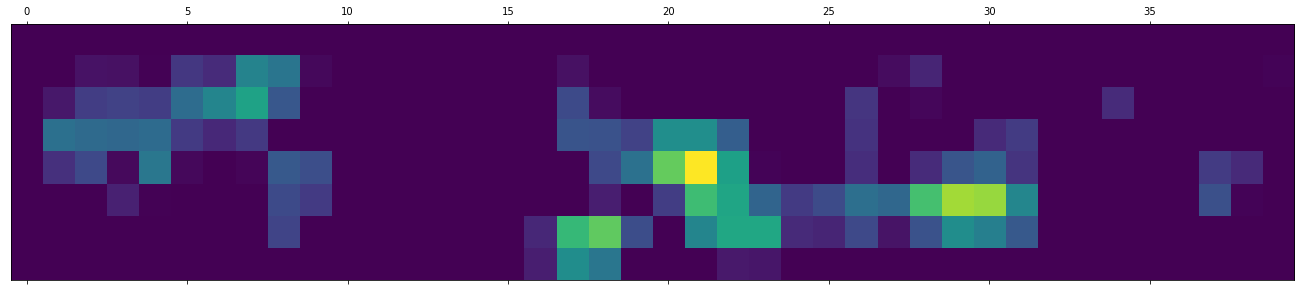

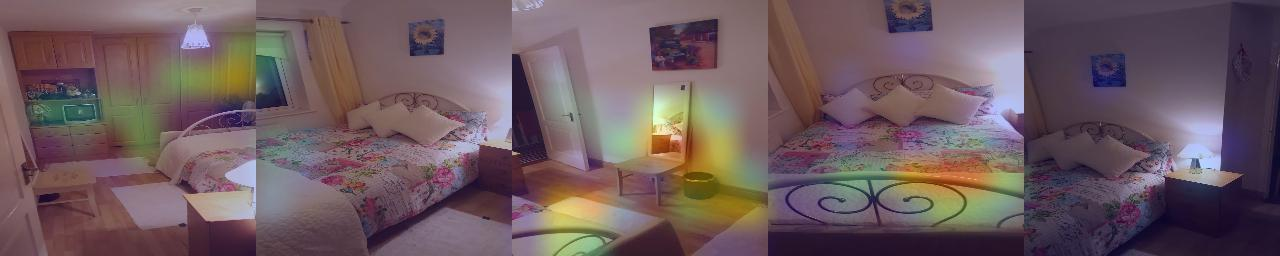

Predicted:  90.46305
True:  78.000015


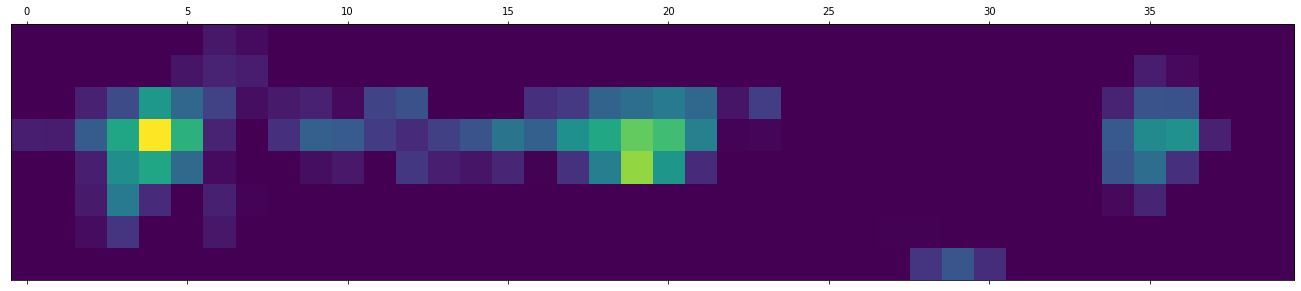

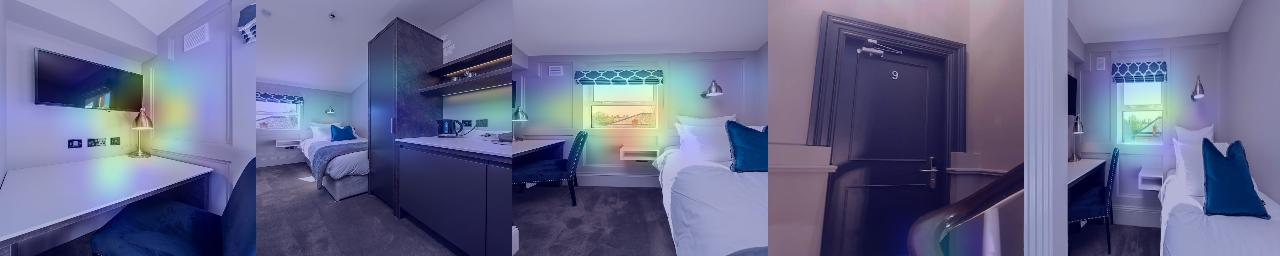

Predicted:  25.115969
True:  89.00001


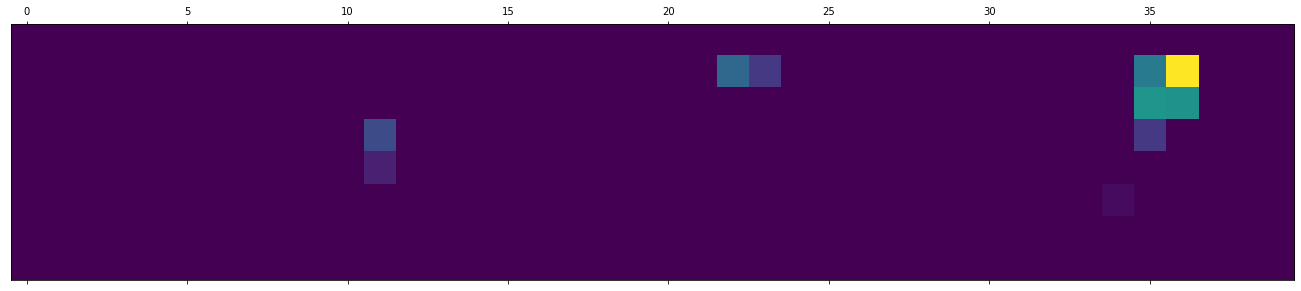

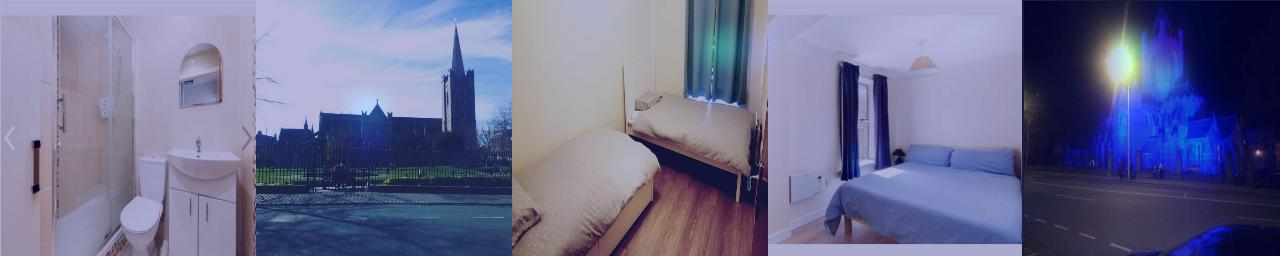

Predicted:  78.44178
True:  55.000004


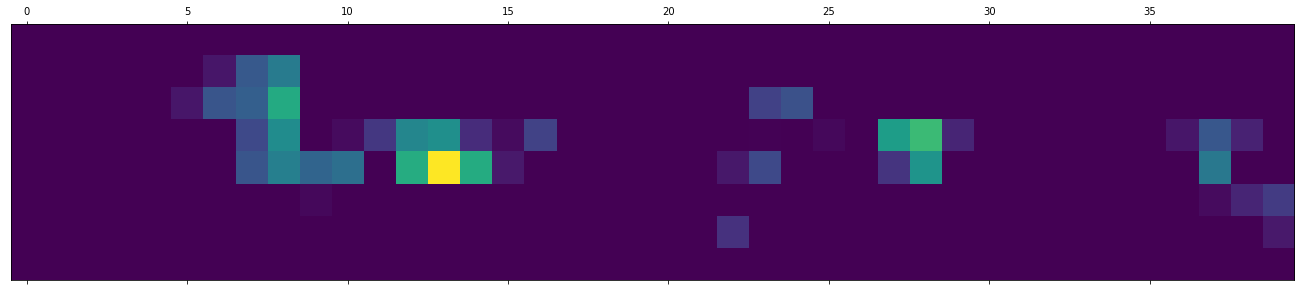

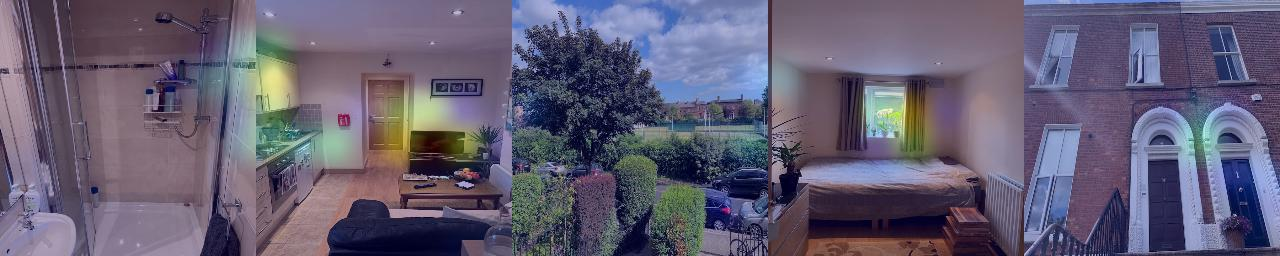

Predicted:  38.700565
True:  40.0


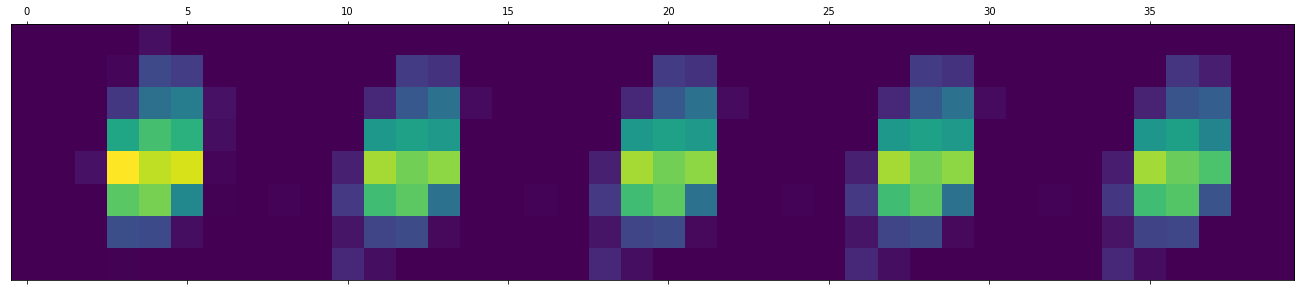

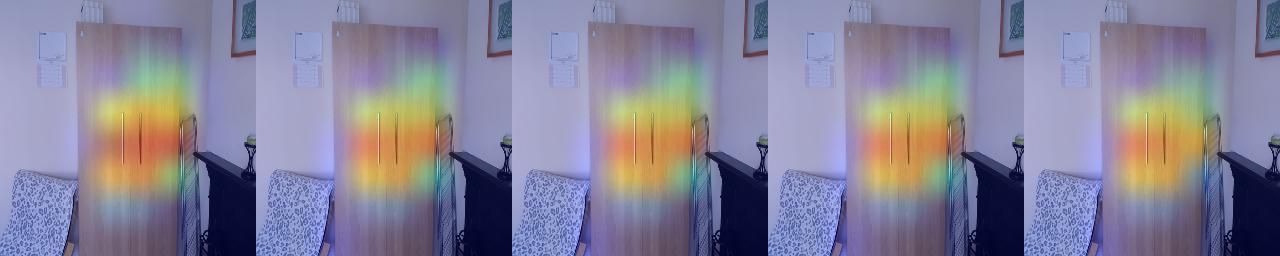

Predicted:  55.088615
True:  34.0


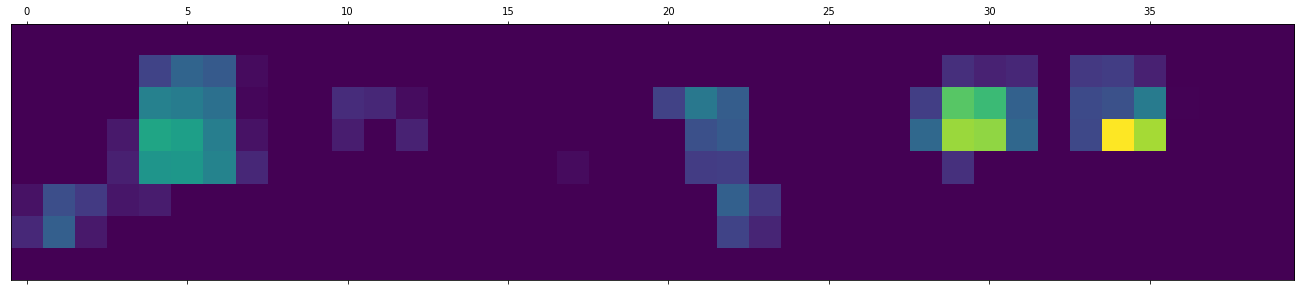

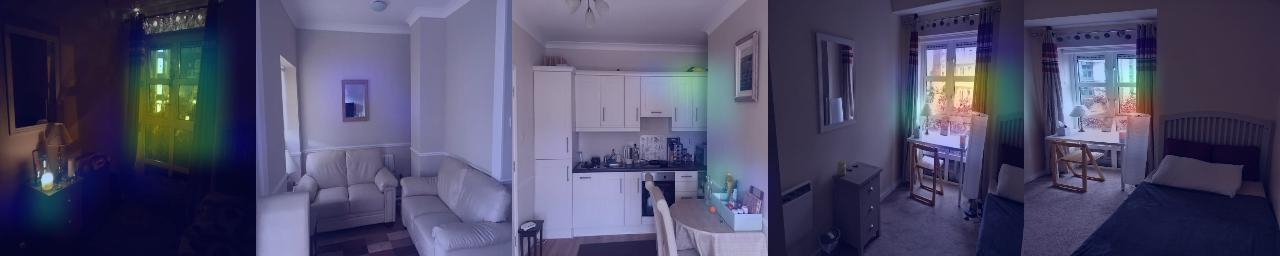

Predicted:  123.67675
True:  200.00002


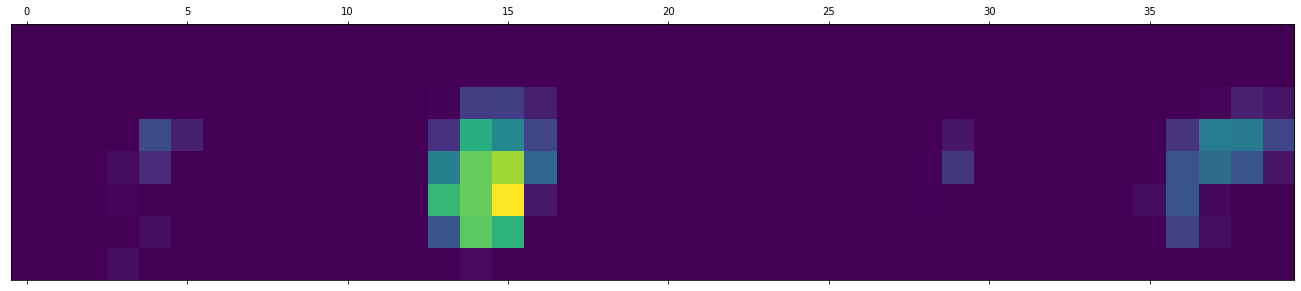

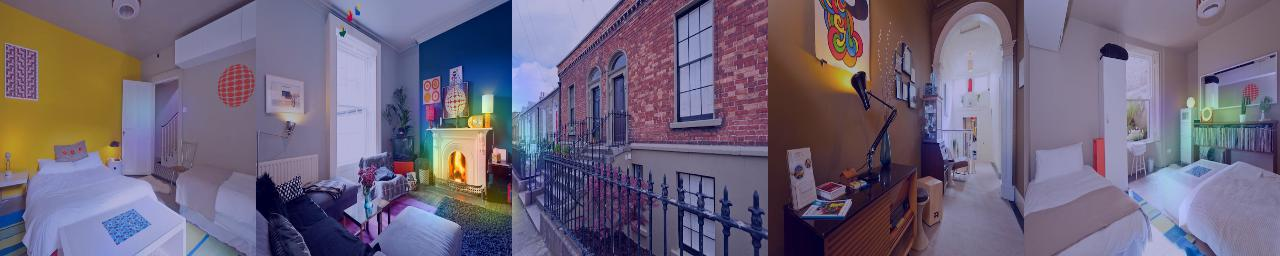

Predicted:  116.896965
True:  100.00001


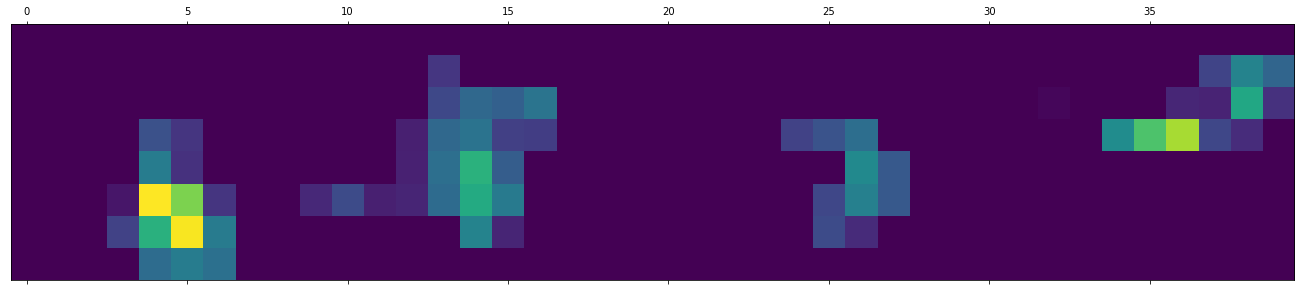

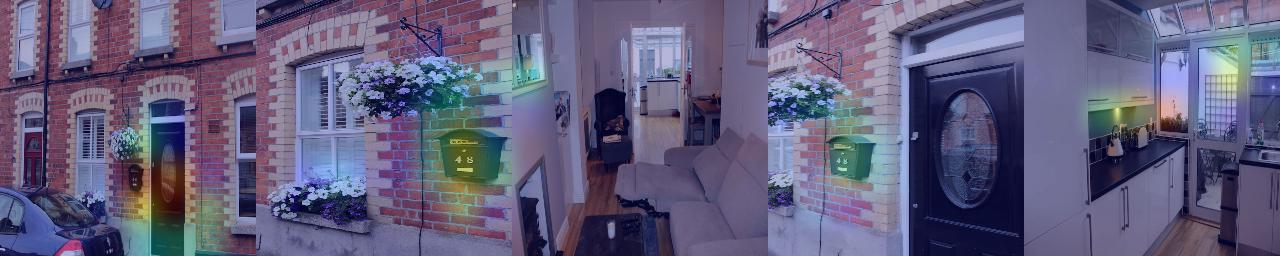

Predicted:  34.030087
True:  55.000004


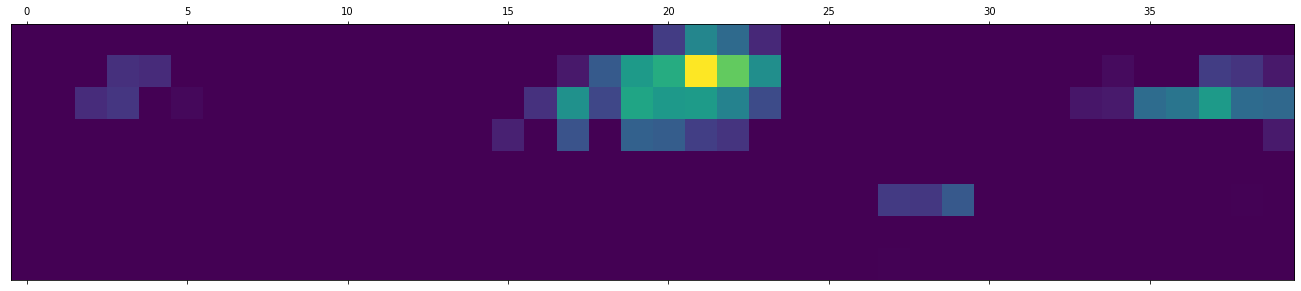

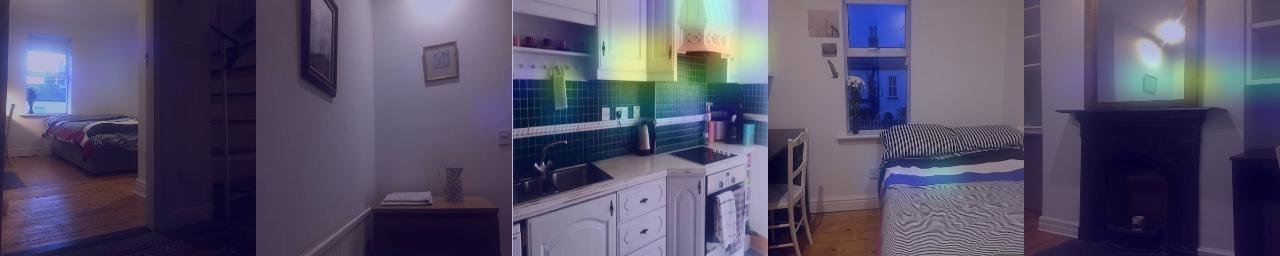

Predicted:  43.175926
True:  50.000004


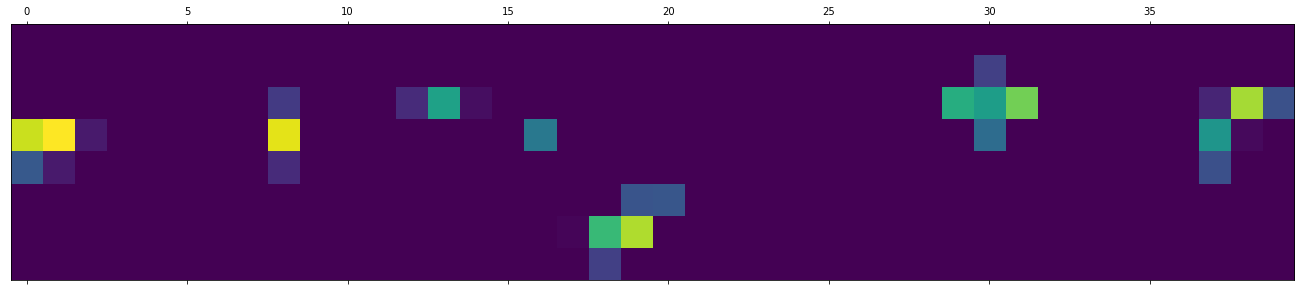

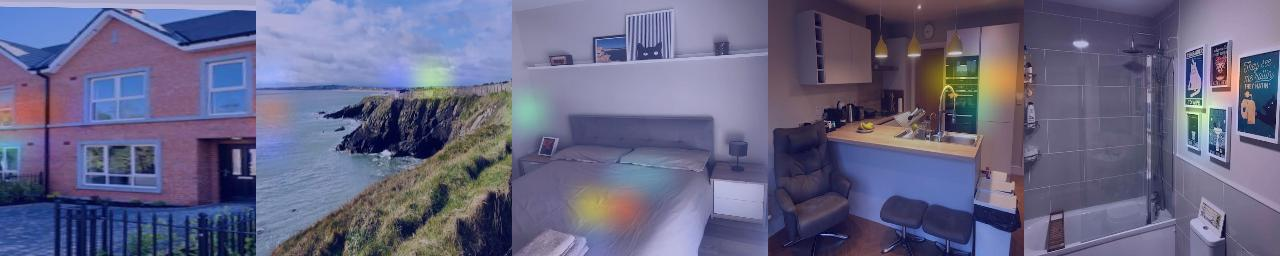

Predicted:  115.08728
True:  168.99997


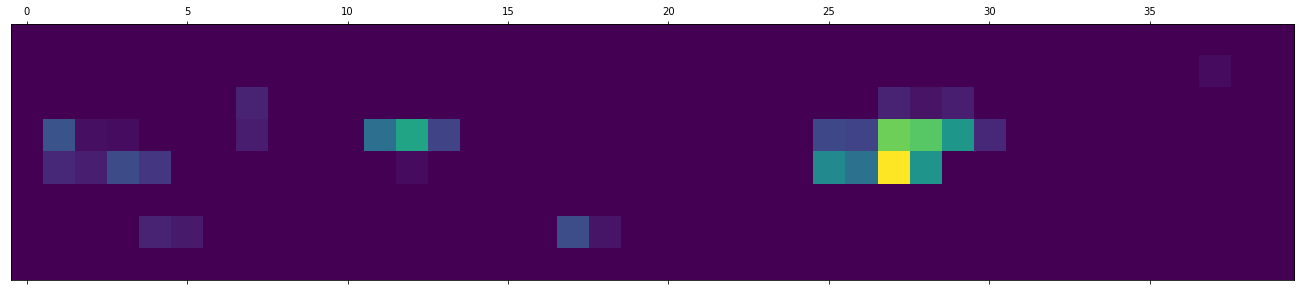

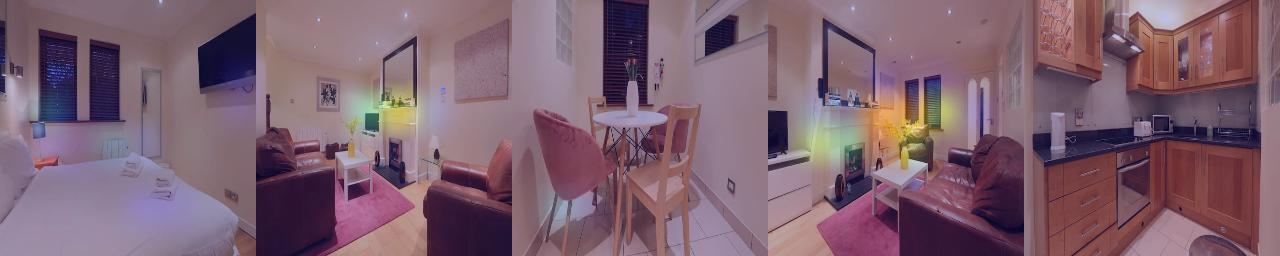

Predicted:  123.802956
True:  102.0


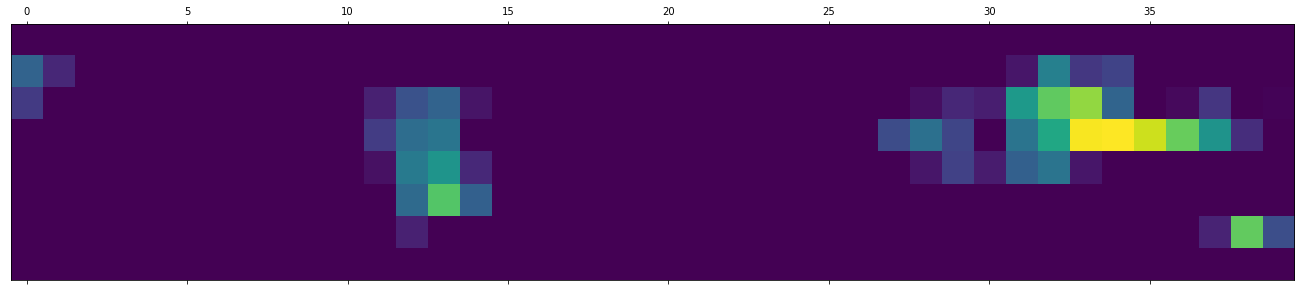

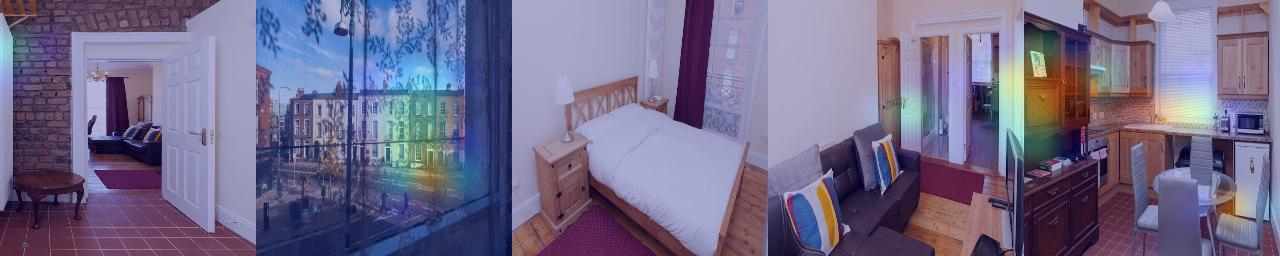

Predicted:  34.02746
True:  69.99999


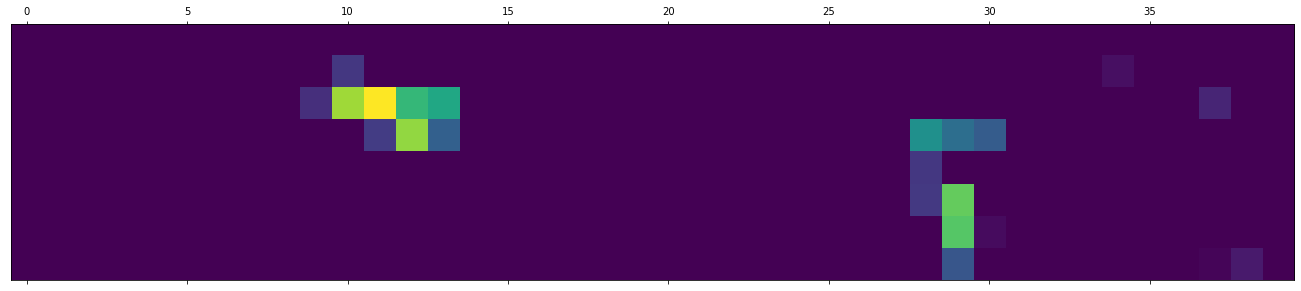

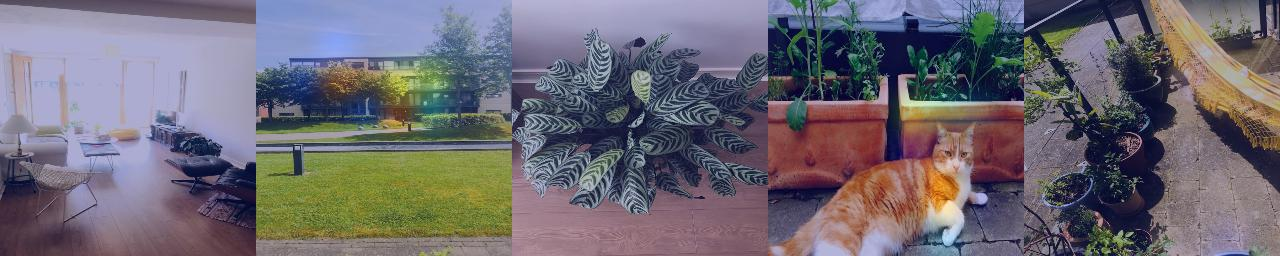

Predicted:  79.77411
True:  518.0


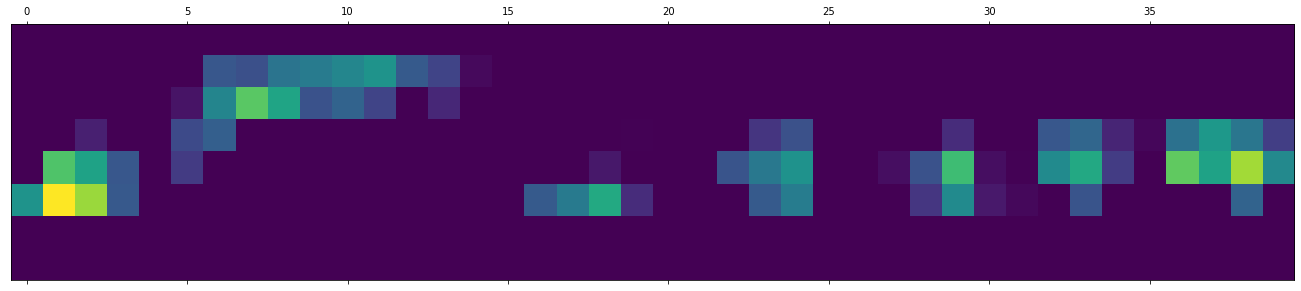

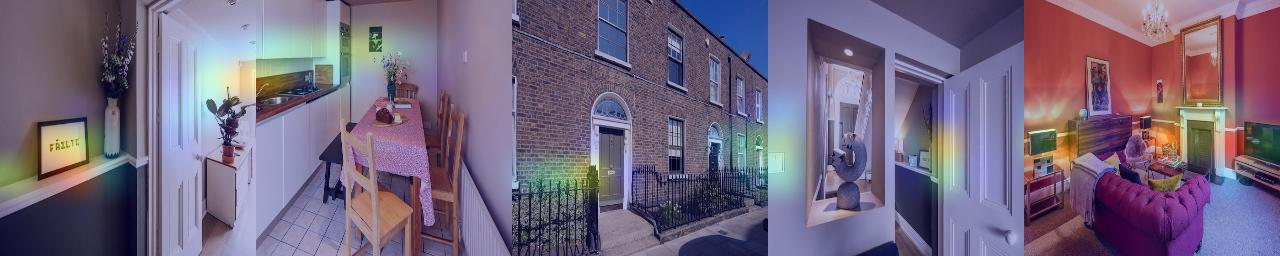

Predicted:  86.43511
True:  69.0


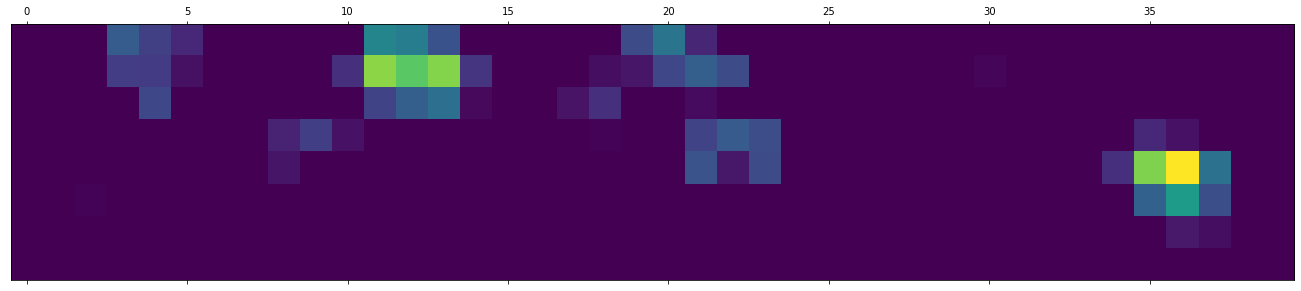

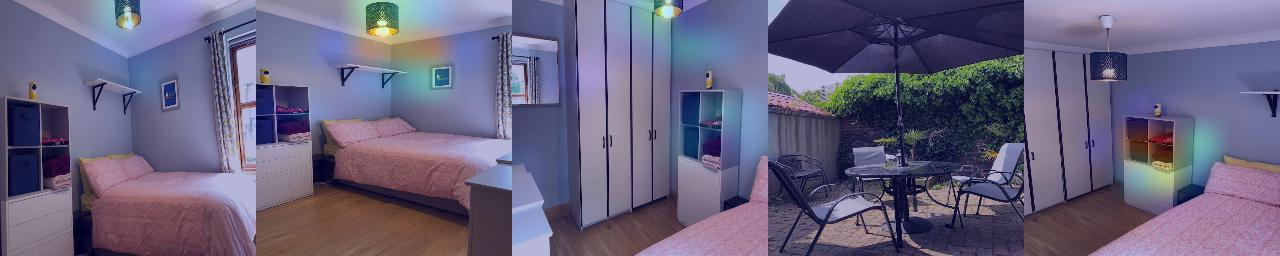

Predicted:  56.355328
True:  40.0


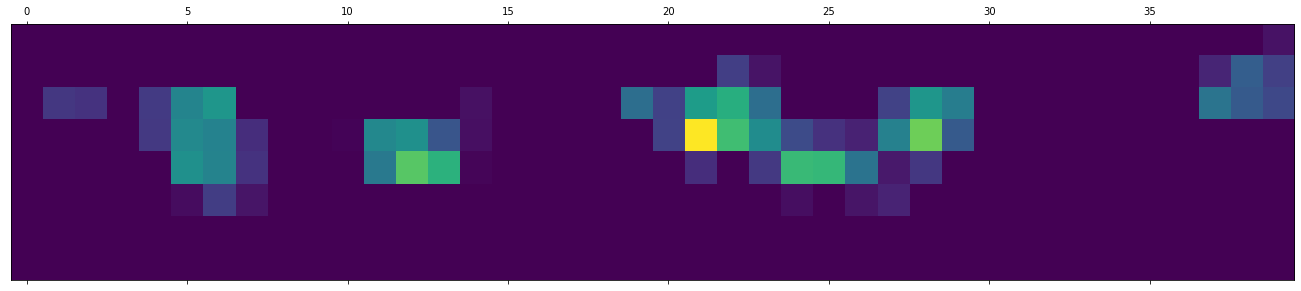

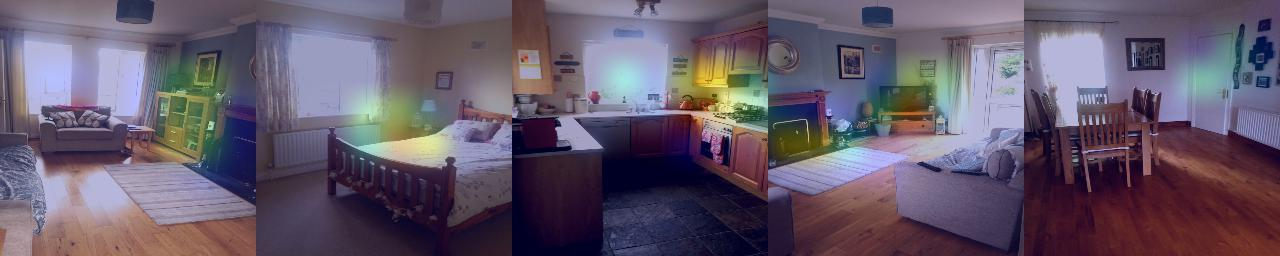

Predicted:  91.05656
True:  1026.0


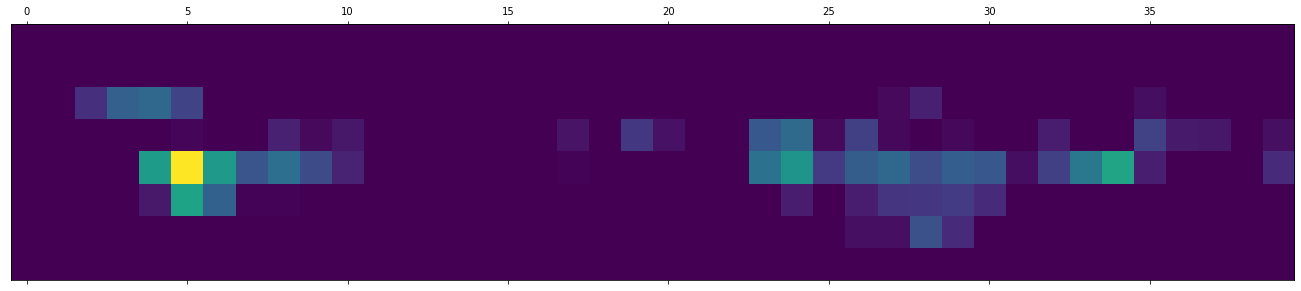

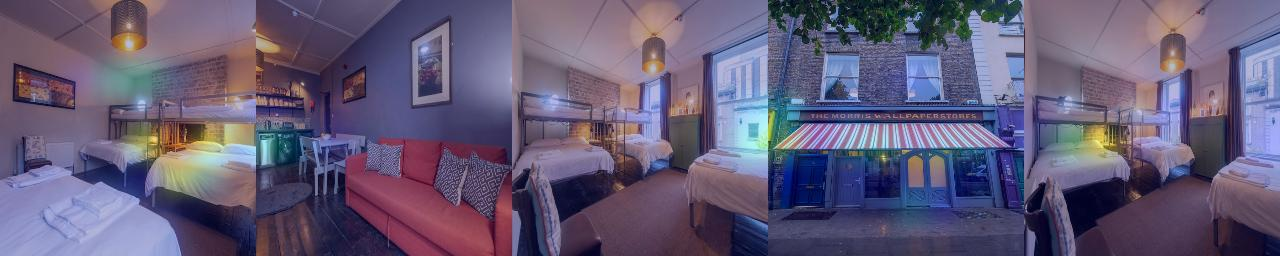

Predicted:  163.71481
True:  500.00006


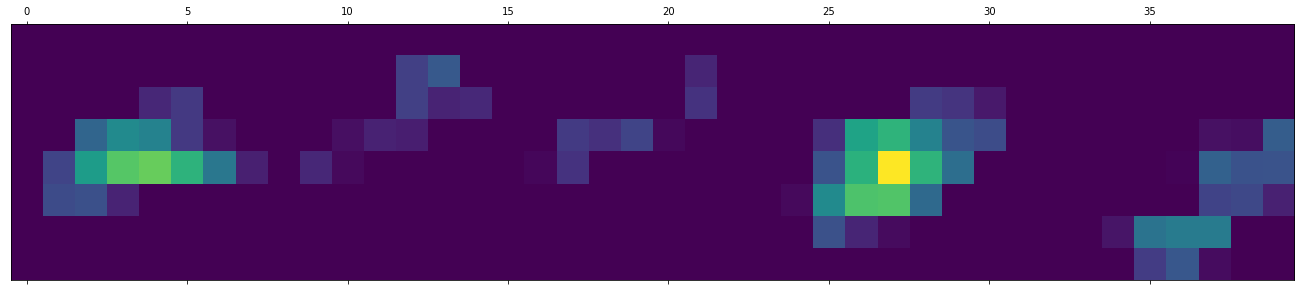

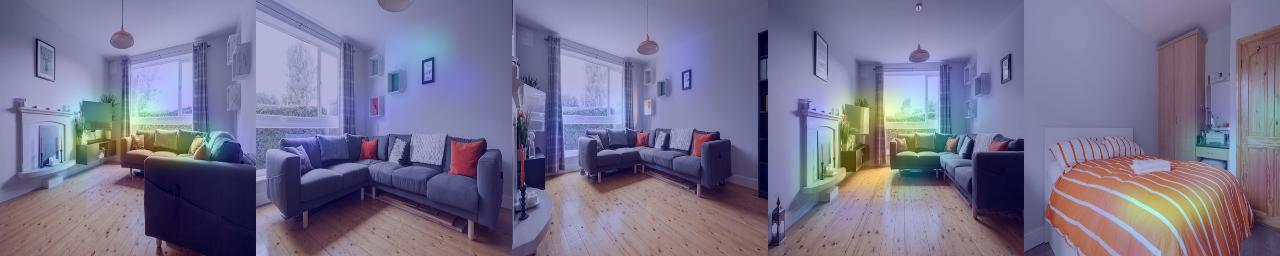

Predicted:  23.886248
True:  128.99998


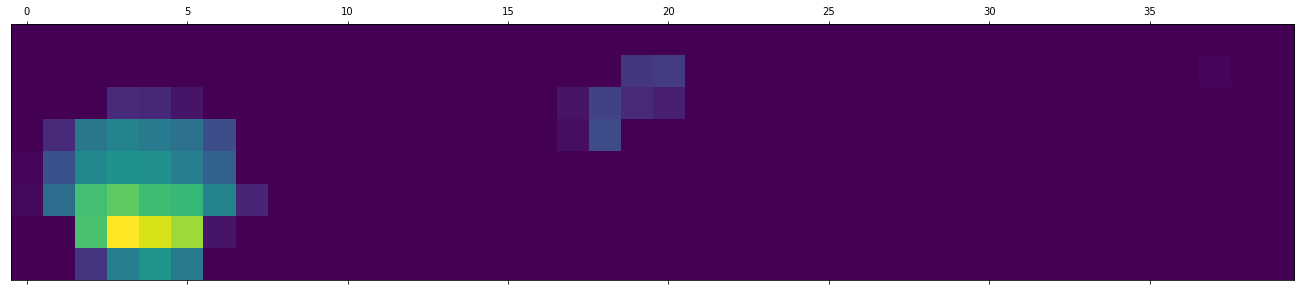

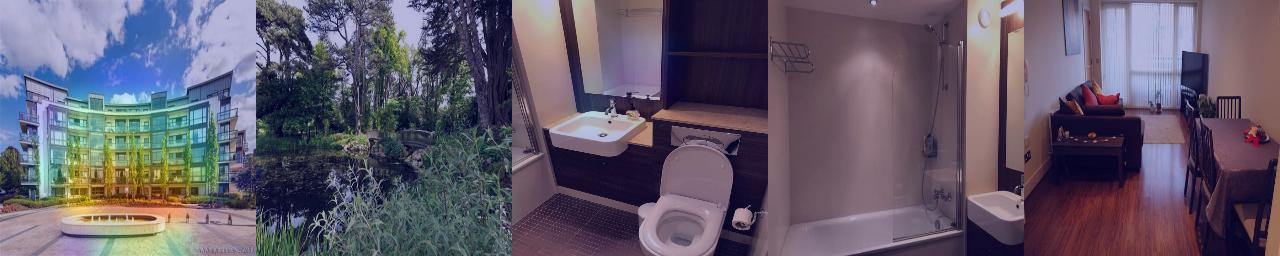

Predicted:  33.28763
True:  35.000004


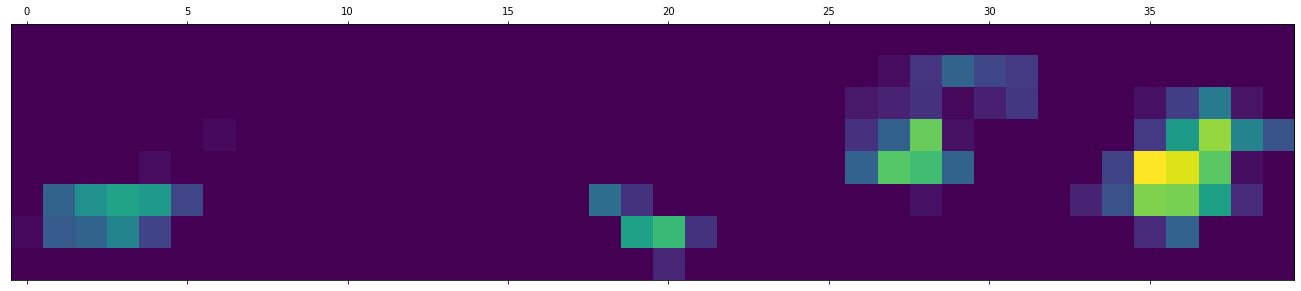

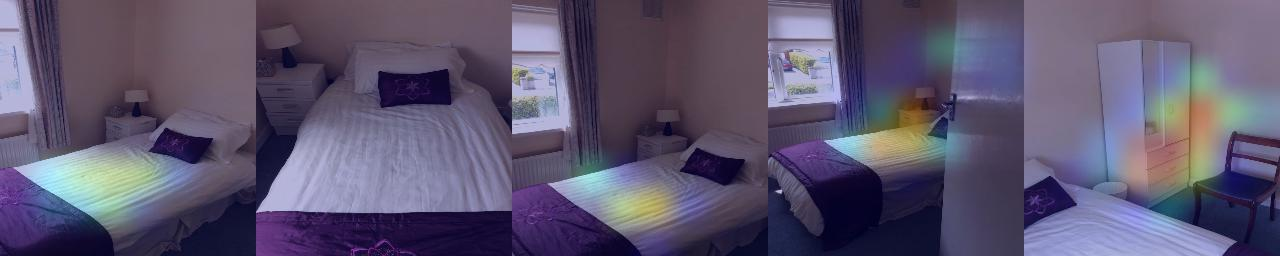

Predicted:  25.575878
True:  55.000004


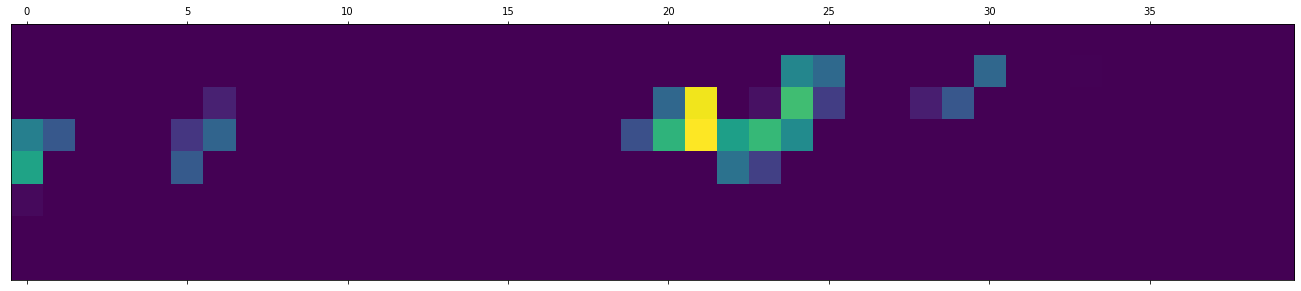

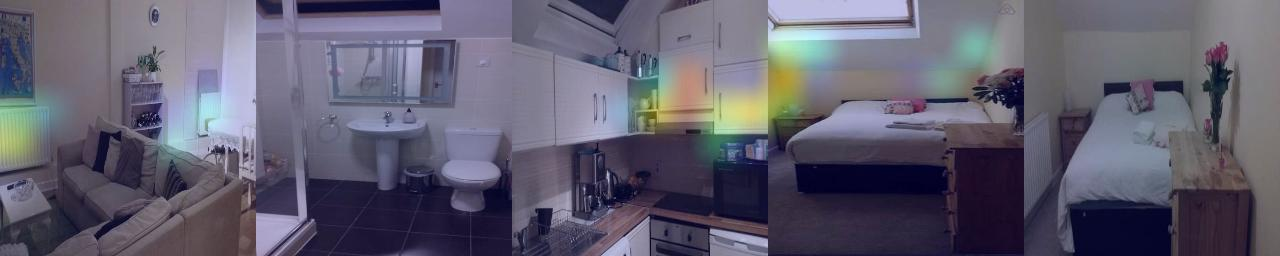

Predicted:  47.61771
True:  130.00003


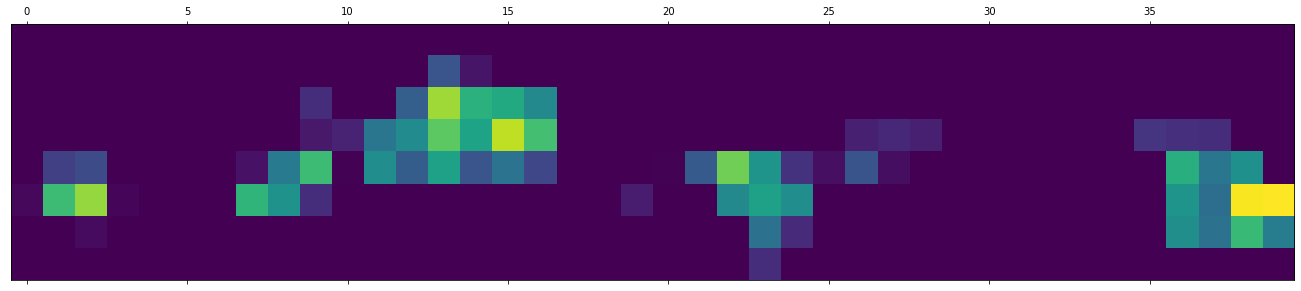

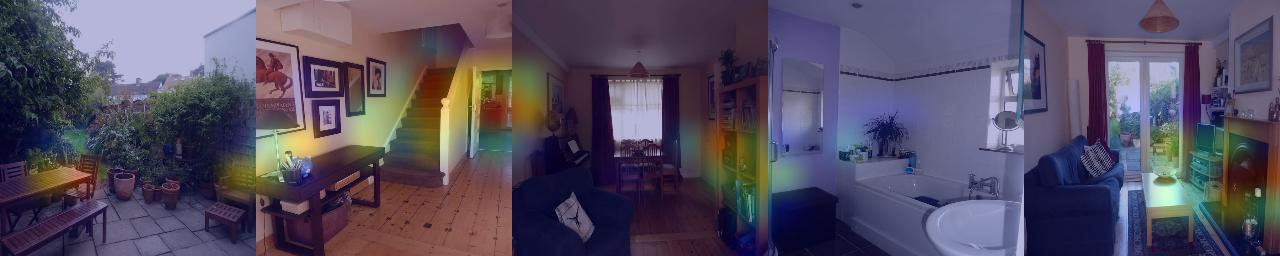

Predicted:  73.362686
True:  100.00001


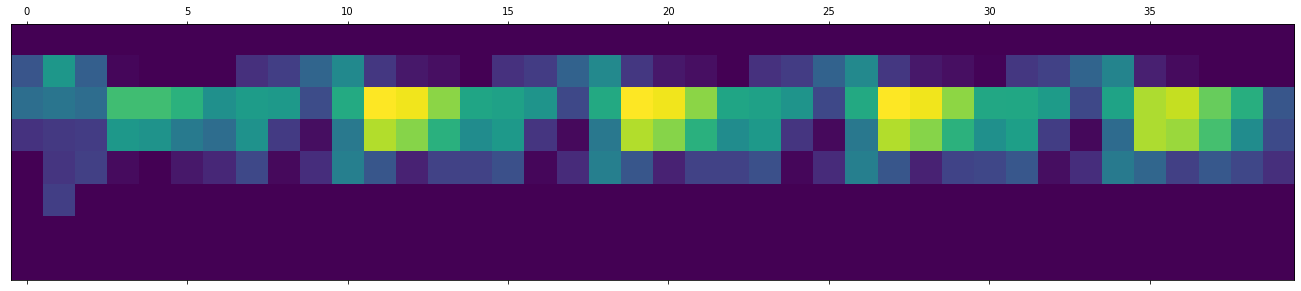

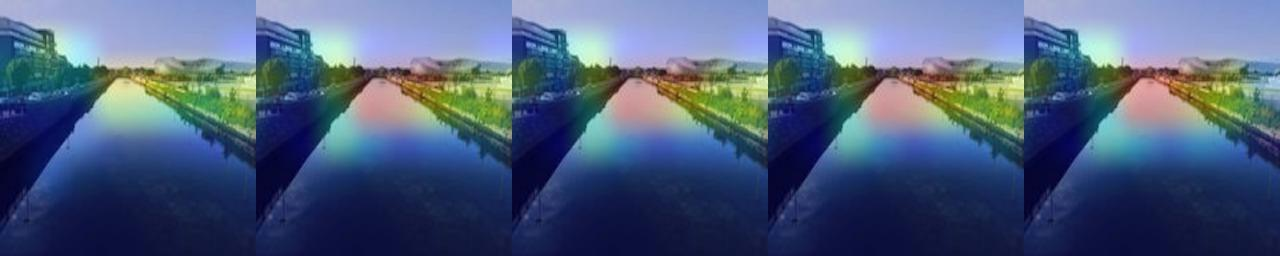

Predicted:  58.375034
True:  60.000004


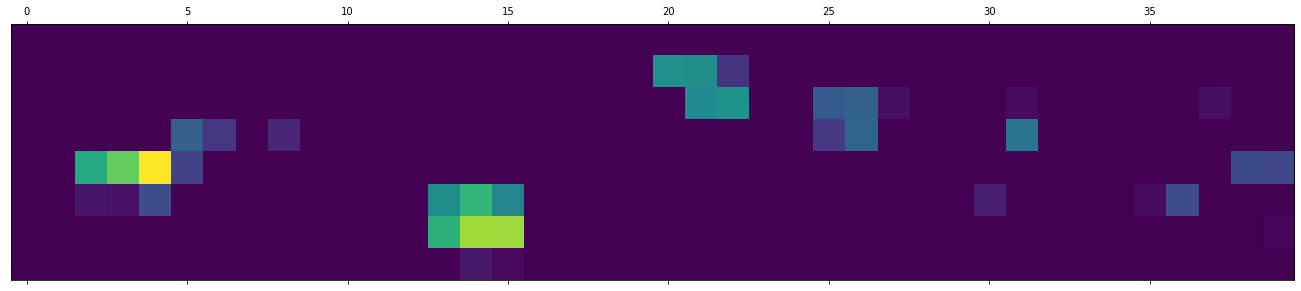

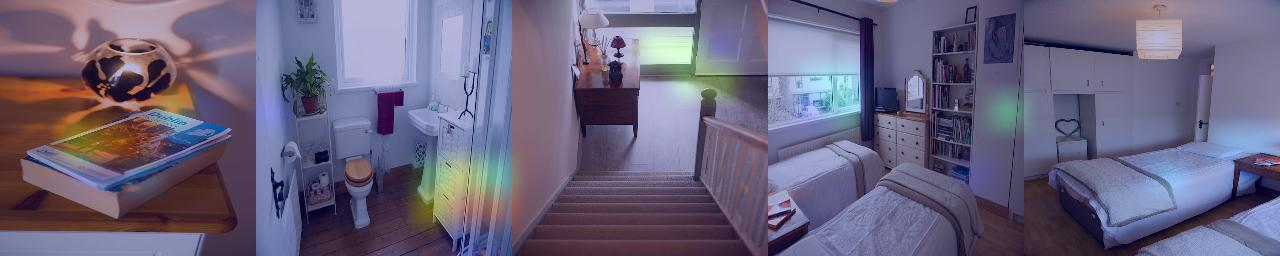

Predicted:  32.473206
True:  104.000015


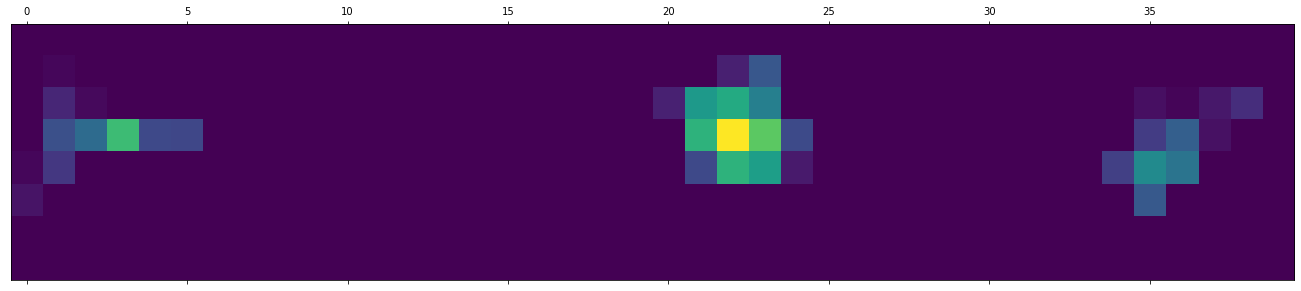

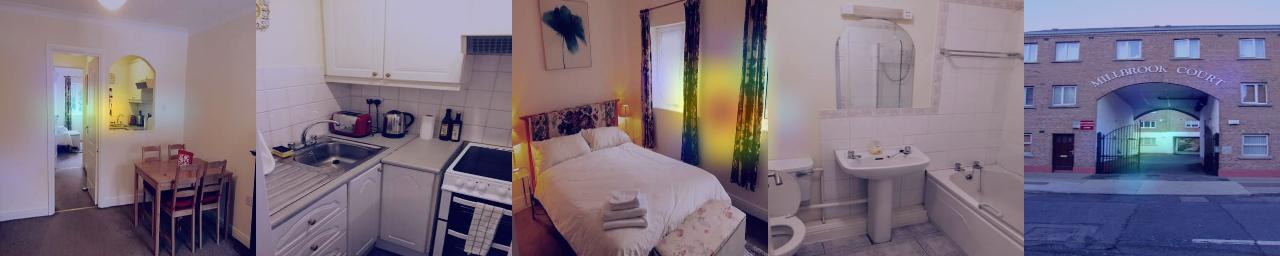

Predicted:  82.78429
True:  78.000015


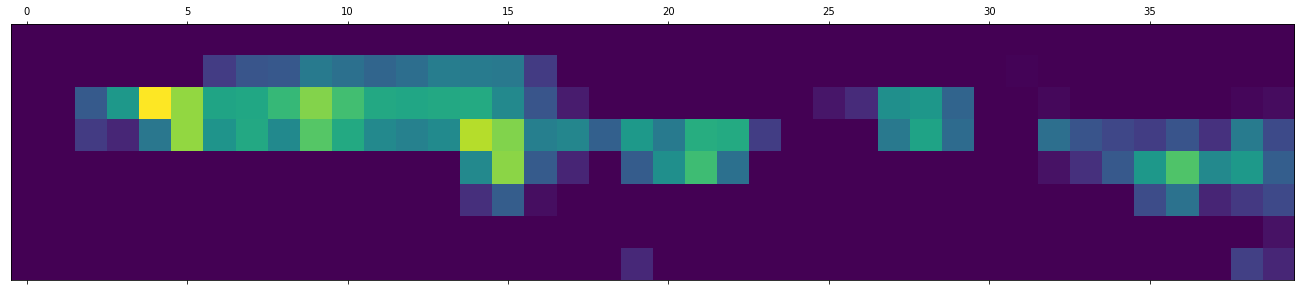

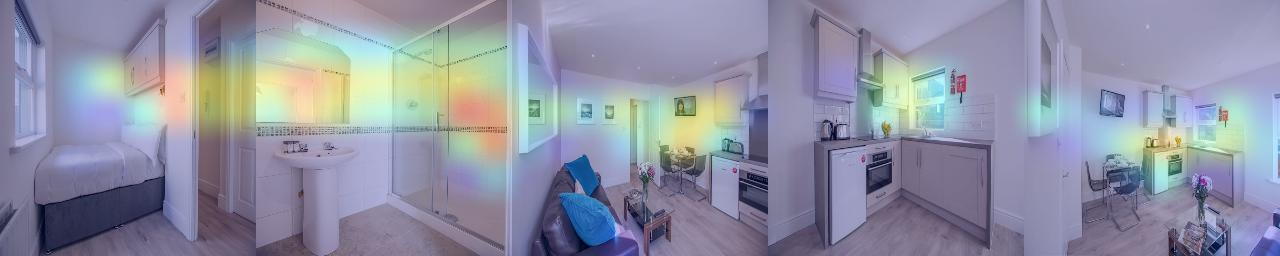

In [23]:
for i in range(b):
  img_array = img_arrays[i]
  img_size = (w,h)
  img_array = preprocess_input(np.expand_dims(img_array, axis=0))

  # Print what the top predicted class is
  preds = model_resnet.predict(img_array)
  print("Predicted: ", np.exp(np.squeeze(preds)))
  print("True: ", np.exp(np.squeeze(prices[i])))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model_resnet, last_conv_layer_name)

  # Display heatmap
  plt.figure(figsize=(23,16))
  plt.matshow(heatmap, fignum = 1)
  ax = plt.gca()
  ax.axes.yaxis.set_visible(False)
  plt.show()

  img_array = img_arrays[i]
  img_array = img_array.numpy().astype(float)

  save_and_display_gradcam(img_array, heatmap)

## EfficientNet

In [31]:
inputs = tf.keras.layers.Input(shape = (None, None, 3), name = "input_1")
#inputs = keras.applications.efficientnet.preprocess_input(inputs)
efficientnet = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', pooling = "avg", input_tensor = inputs)
efficientnet.trainable = False

outputs = tf.keras.layers.Flatten()(efficientnet.output)
outputs = tf.keras.layers.Dense(100, activation = "relu")(outputs)

outputs = tf.keras.layers.Dense(1)(outputs)


model_effnet = tf.keras.Model(inputs, outputs)

model_effnet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss="mean_squared_error", metrics=["mean_squared_error"])
model_effnet.fit(train_dataset)

/Users/dmnk/miniforge3/envs/tensorflow_m1/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2022-01-03 17:21:52.865870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1263/1263 [==============================] - 219s 171ms/step - loss: 0.5367 - mean_squared_error: 0.5367


In [32]:
# get test cases
for i in val_dataset.take(1):
  img_arrays = i[0]["input_1"]
  prices = i[1]

model_builder = model_effnet
preprocess_input = keras.applications.efficientnet.preprocess_input
last_conv_layer_name = "top_conv"
b, w, h, d = img_arrays.shape

Predicted:  43.447456
True:  50.499996


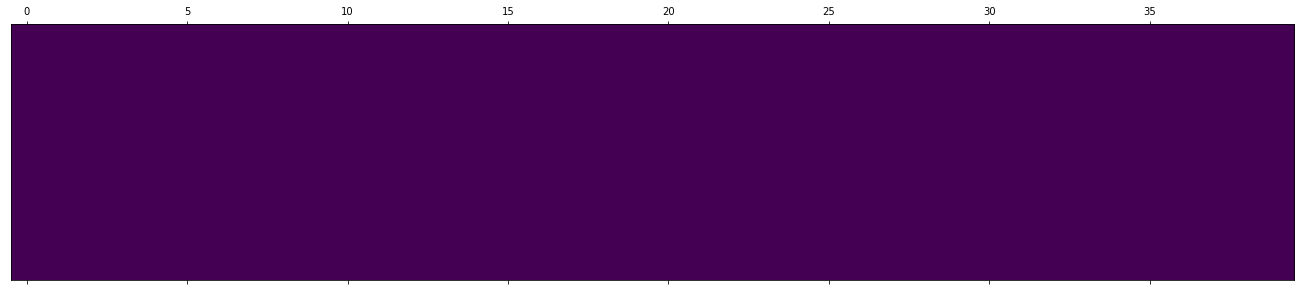

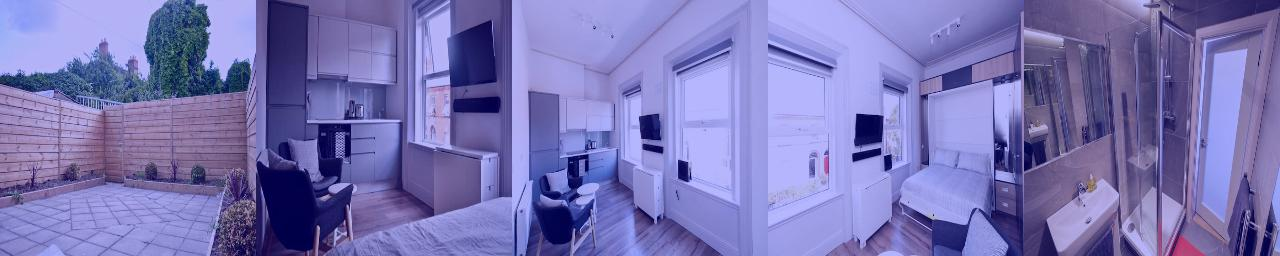

Predicted:  1.0589375
True:  55.000004


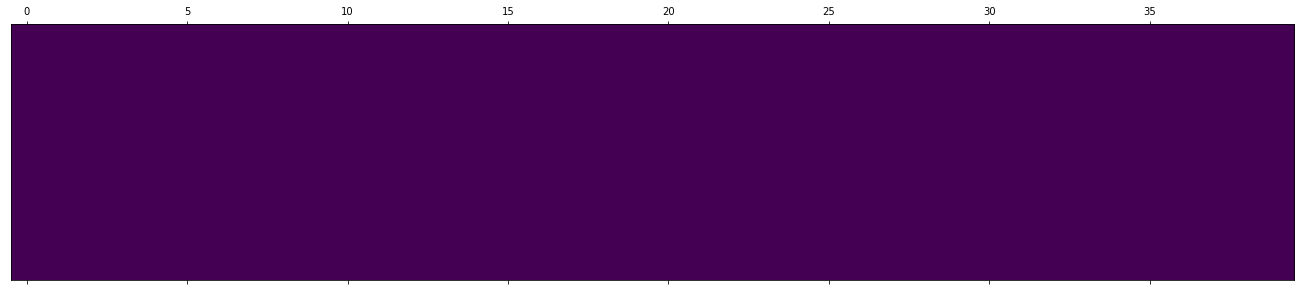

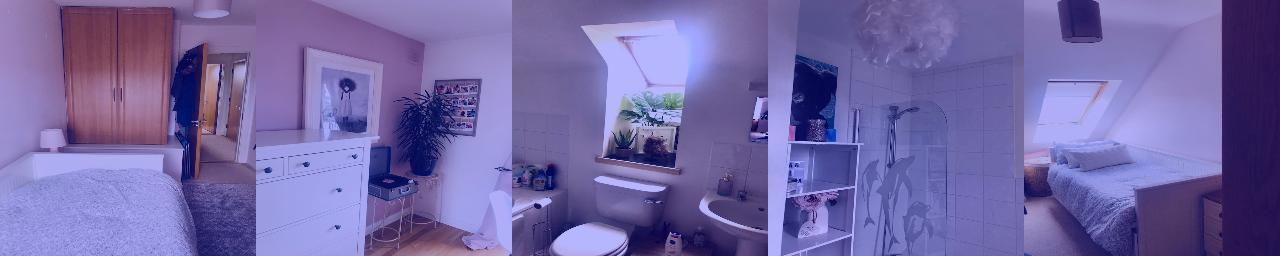

Predicted:  1.0589375
True:  31.666666


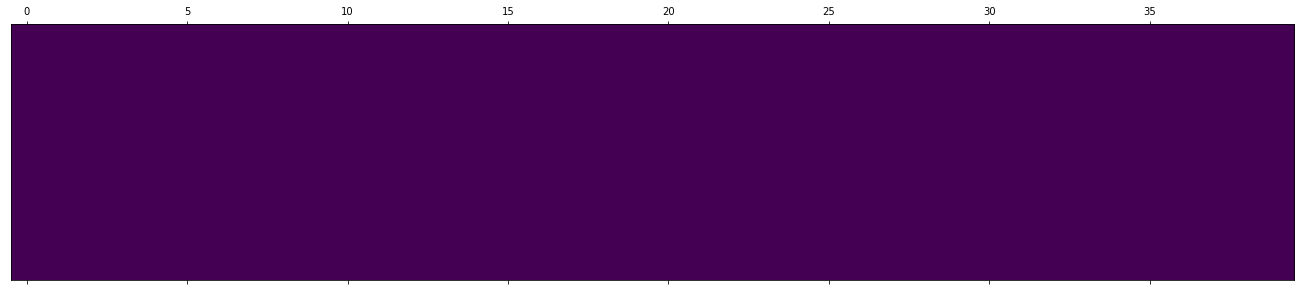

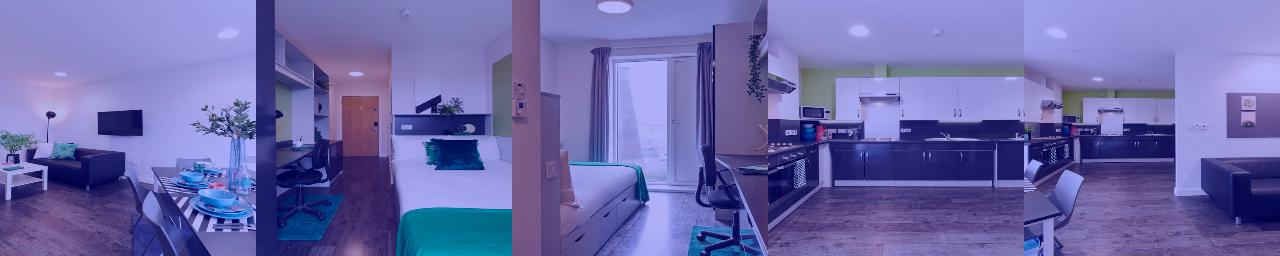

In [35]:
for i in range(b):
  img_array = img_arrays[i]
  img_size = (w,h)
  img_array = preprocess_input(np.expand_dims(img_array, axis=0))

  # Print what the top predicted class is
  preds = model_effnet.predict(img_array)
  print("Predicted: ", np.exp(np.squeeze(preds)))
  print("True: ", np.exp(np.squeeze(prices[i])))

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model_effnet, last_conv_layer_name)

  # Display heatmap
  plt.figure(figsize=(23,16))
  plt.matshow(heatmap, fignum = 1)
  ax = plt.gca()
  ax.axes.yaxis.set_visible(False)
  plt.show()

  img_array = img_arrays[i]
  img_array = img_array.numpy().astype(float)

  save_and_display_gradcam(img_array, heatmap)

# Model for single images

Next, write tf-record files which contain the images and prices for each id

In [ ]:
raise Exception("Stop!")
for id in tqdm(unique_ids):
    filter = df_compl["id"] == id
    data_to_write = df_compl[filter]
    # for computational reasons, only take first picture
    data_to_write = data_to_write[data_to_write["img_no"]=="0"]
    filename = folder_tfrecord +"/"+ id
    write_features(data_to_write["id"].values, data_to_write["path"].values, data_to_write["log_price"].values, path = folder_images+"/", filename = filename)


Exception: Stop!

Split data in training, test and validation ids, store corresponding tf-record data and create datasets

In [ ]:
X_train, X_test = train_test_split(unique_ids, test_size=0.2, random_state=1)

X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [ ]:
X_train = [folder_tfrecord + "/" + f + ".tfr" for f in X_train.astype(str)]
X_test = [folder_tfrecord + "/" + f + ".tfr" for f in X_test.astype(str)]
X_val = [folder_tfrecord + "/" + f + ".tfr" for f in X_val.astype(str)]

In [ ]:
train_dataset = make_dataset(X_train, batch_size = 10)
test_dataset = make_dataset(X_test, batch_size = 10)
val_dataset = make_dataset(X_val, batch_size = 10)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [ ]:
basemodel = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False, weights='imagenet', pooling = "avg", input_tensor = tf.keras.layers.Input(shape = (256, 256, 3), name = "input_1")
)
basemodel.trainable = False

outputs = tf.keras.layers.Dense(100, activation = "relu")(basemodel.output)
outputs = tf.keras.layers.Dense(1)(outputs)

model = tf.keras.Model(basemodel.input, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
              loss=tf.keras.losses.MeanSquaredError())
model.fit(train_dataset)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-29 13:17:45.983243: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-29 13:17:45.983782: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


    378/Unknown - 115s 299ms/step - loss: 6.0016

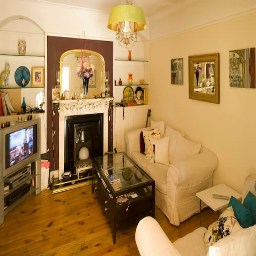

In [ ]:
model_builder = model

preprocess_input = keras.applications.efficientnet.preprocess_input

last_conv_layer_name = "top_conv"

# The local path to our target image"
img_path = "data/images_resized/44077_1.png"

display(Image(img_path))

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
[[7.352597]]


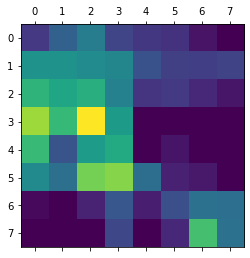

In [ ]:
img_size = (256,256)
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
#model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print(preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

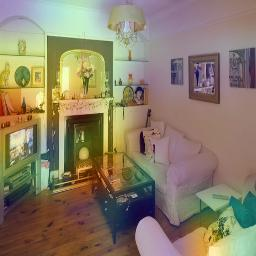

In [ ]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)